In [1]:
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=10 --xla_cpu_enable_fast_math=true'

import jax
print(jax.devices())

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np
import jax.numpy as jnp
import jax 
from jax import grad, vmap
jax.config.update("jax_enable_x64", True)




import scipy.interpolate as interp
import scipy.integrate as integ
import scipy.linalg as sla

import fisher_jim_tgr_v3 as lib
import pycbc.conversions

import astropy.units as u
from astropy import constants as const

Ms = (u.Msun * const.G / const.c**3 ).si.value
from datetime import datetime
datestr = datetime.now().strftime('%m-%d-%y')

import sys
import matplotlib as mpl

# Clear matplotlib from sys.modules
for module in list(sys.modules.keys()):
    if module.startswith("matplotlib"):
        del sys.modules[module]

import matplotlib.pyplot as plt
plt.style.use("paper.mplstyle")
%config InlineBackend.figure_format = 'retina'
obj = lib.Fisher(fmin = 10, fmax = 2000, n_freq = 4000.)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7), CpuDevice(id=8), CpuDevice(id=9)]


In [2]:
full_str = ["M_c", "eta", "d_L", "ra", "dec", "iota", "psi", "t_c", "phase_c", "zco", "rng", "Mc_source", "snr_H1", "snr_L1", "snr_V1", "snr_t"]
names = full_str[0:9]
# data = np.loadtxt("data/events.txt")
data = jnp.array(np.loadtxt("data/5-year-data-O3/5-year-data-O3-events.txt"))
# data = jnp.array(nnp.loadtxt("data/5-year-data-CE/5-year-data-CE-events.txt"))



data_150914 = np.array(data[1])
data_150914[0] = 3
q  = 0.79
data_150914[1] = q/(1+q)**2
data_150914[2] = 390/10

idx = '150914'
if idx=='150914':
    data_150914 = np.array(data[1])
    data_150914[0] = 30
    q  = 0.79
    data_150914[1] = q/(1+q)**2
    data_150914[2] = 390
    dat = jnp.array(data_150914)
elif idx=='170817':
    data_150914 = np.array(data[1])
    data_150914[0] = 3
    q  = 0.79
    data_150914[1] = q/(1+q)**2
    data_150914[2] = 390/10
    dat = jnp.array(data_150914)

red_param = dict(zip(names, jnp.array(dat).T))


epsilon = jnp.array(1e-6)
for key in ['s1_x', 's1_y', 's1_z', 's2_x', 's2_y', 's2_z']:
    red_param[key] = epsilon
zero_vector = jnp.array(0.)
for key in ['gmst', 'epoch']:
    red_param[key] = zero_vector

x = red_param.copy()
x['s1_z'] = 0.
x['s1_x'] = 0.

prec_pe = True
if prec_pe:
    i = None
else:
    i = -2
hgr = obj.get_h_gr(x)
dhgr = obj.get_dh_gr(x)
paramgr = obj.paramdiffgr.copy()[:i]
paramgr_latex = obj.paramdiffgr_latex.copy()[:i]
freqs = obj.freqs.copy()

In [3]:

kinj = 3
norm = np.abs(lib.get_dpsi_ppe(20, x, kinj)- lib.get_dpsi_ppe(6000, x, kinj)) 
dphik = 0.3/norm
dpsi_inj = dphik*lib.get_dpsi_ppe(obj.freqs, x, kinj)


Dh = {}
for d in ["H1", "L1", "V1"]:
    Dh[d] = 1j * dpsi_inj * hgr[d]

fi = obj.compute_joint_fish(x, paramgr, k = None)
bias_ip = obj.compute_biasip(x, Dh, paramgr, k = None)

idx_par = obj.idx_par.copy()
log_flag = obj.log_flag.copy()

In [4]:
cov = jnp.linalg.inv(fi)
dx_bias = np.array(cov @ bias_ip)
dx_stat = np.diagonal(np.array(cov ))**(1/2)
xvals = np.array([x[k] for k in paramgr])

dhpara = np.zeros_like(freqs)
for p in paramgr:
    if log_flag[p]:
        i = idx_par[p]
        dx_bias[i] = dx_bias[i]*x[p]
        dx_stat[i] = dx_stat[i]*x[p]

    dhpara = dhpara + dx_bias[i]*dhgr["H1"][p]

In [5]:
import pandas as pd

from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args, titles=cycle([''])):
    html_str = ""
    for df, title in zip(args, chain(titles, cycle(['']))):
        html_str += f'<div style="display: inline-block; vertical-align: top; padding-right: 20px;">'
        html_str += f'<h3 style="text-align: center;">{title}</h3>'
        html_str += df.to_html(escape=False)  # Use escape=False to allow LaTeX rendering
        html_str += '</div>'
    display_html(html_str, raw=True)

xvaltrue = np.append(xvals,[dphik])
paramxtrue_latex = paramgr_latex + [rf"$\delta\varphi_{ kinj }$"]
df1 = pd.DataFrame(xvaltrue,paramxtrue_latex, [r"$\Theta_\mathrm{t}$"]).round(3)
df2 = pd.DataFrame(dx_bias, paramgr_latex, columns=[r"$\Delta\Theta_\mathrm{bias}$"]).round(3)
df3 = pd.DataFrame(dx_stat, paramgr_latex, [r"$\Delta\Theta_\mathrm{stat}$"]).round(3)

snr_latex = [r"$\rho_H$","$\rho_L$","$\rho_V$","$\rho_N$"]
snrarr = np.real(np.array(list(obj.get_snrs_gr(x).values())))
df4 = pd.DataFrame(snrarr,snr_latex, [r"$\rho$"]).round(1)
display_side_by_side(df1,df2, df3, df4)
# display_side_by_side(df1,df2, df3)

,$\Theta_\mathrm{t}$
$M_c$,30.000
$\eta$,0.247
$d_L$,390.000
$\text{ra}$,1.856
$\text{dec}$,-0.073
$\iota$,1.053
$\psi$,0.980
$t_c$,0.000
$\phi_c$,0.000
$s_{1x}$,0.000


In [6]:
def get_stuff(kinj):
    norm = lib.get_dpsi_ppe(20, x, kinj)- lib.get_dpsi_ppe(6000, x, kinj)
    dphik = 1/norm
    dpsi_inj = dphik*lib.get_dpsi_ppe(obj.freqs, x, kinj)
    
    Dh = {}
    
    for d in ["H1", "L1", "V1"]:
        Dh[d] = 1j * dpsi_inj * hgr[d] 
    normarr = [lib.innprod(Dh[d], Dh[d], obj.psdO3, obj.freqs) for d in ["H1", "L1", "V1"]]
    norm = np.sum(normarr)**(1/2) / 5
    dpsi_inj = dpsi_inj/norm
    for d in ["H1", "L1", "V1"]:
        Dh[d] = Dh[d]/norm

    # normarr = [lib.innprod(Dh[d], Dh[d], obj.psdO3, obj.freqs) for d in ["H1", "L1", "V1"]]
    # print(norm)


    fi = obj.compute_joint_fish(x, paramgr, k = None)
    bias_ip = obj.compute_biasip(x, Dh, paramgr, k = None)
    
    idx_par = obj.idx_par.copy()
    log_flag = obj.log_flag.copy()
    
    cov = jnp.linalg.inv(fi)
    dx_bias = np.array(cov @ bias_ip)
    dx_stat = np.diagonal(np.array(cov ))**(1/2)
    xvals = np.array([x[k] for k in paramgr])

    for p in paramgr:
        if log_flag[p]:
            i = idx_par[p]
            dx_bias[i] = dx_bias[i]*x[p]
            dx_stat[i] = dx_stat[i]*x[p]
    # dhpara = np.zeros_like(freqs)
    dhpara = {}
    dhperp = {}
    for d in ["H1", "L1", "V1"]:
        dhpara[d] = jnp.zeros_like(freqs)
        for p in paramgr:
            dhpara[d] = dhpara[d] +  dx_bias[idx_par[p]]*dhgr[d][p]
            # print(lib.innprod( dx_bias[i]*dhgr[d][p], dhpara[d], obj.psdO3, obj.freqs)**(1/2))
        dhperp[d] = Dh[d] - dhpara[d]
    
    dpsi_perp = np.array((dhperp["H1"])/1j/hgr["H1"])

    snr = np.real(np.sum([lib.innprod(hgr[d], hgr[d], obj.psdO3, obj.freqs) for d in ["H1", "L1", "V1"]])**(1/2))
    snr_dh = np.real(np.sum([lib.innprod(Dh[d], Dh[d], obj.psdO3, obj.freqs) for d in ["H1", "L1", "V1"]])**(1/2))
    snr_dhperp = np.real(np.sum([lib.innprod(dhperp[d], dhperp[d], obj.psdO3, obj.freqs) for d in ["H1", "L1", "V1"]])**(1/2))
    snr_dhpara = np.real(np.sum([lib.innprod(dhpara[d], dhpara[d], obj.psdO3, obj.freqs) for d in ["H1", "L1", "V1"]])**(1/2))
    res = {'freqs' : freqs, 'dpsi_inj' : dpsi_inj, 'dpsi_perp' : dpsi_perp, 'dh' : Dh["H1"], 'h' : hgr["H1"], 'dh_perp' : dhperp["H1"], 'dx_bias' : dx_bias, 'dx_stat' : dx_stat, 'snr':snr, 'snr_dh':snr_dh, 'snr_dhperp':snr_dhperp, 'snr_dhpara':snr_dhpara}



    return res

res = get_stuff(3)

/home/darkknight/anaconda3/envs/geotgr/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/darkknight/anaconda3/envs/geotgr/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


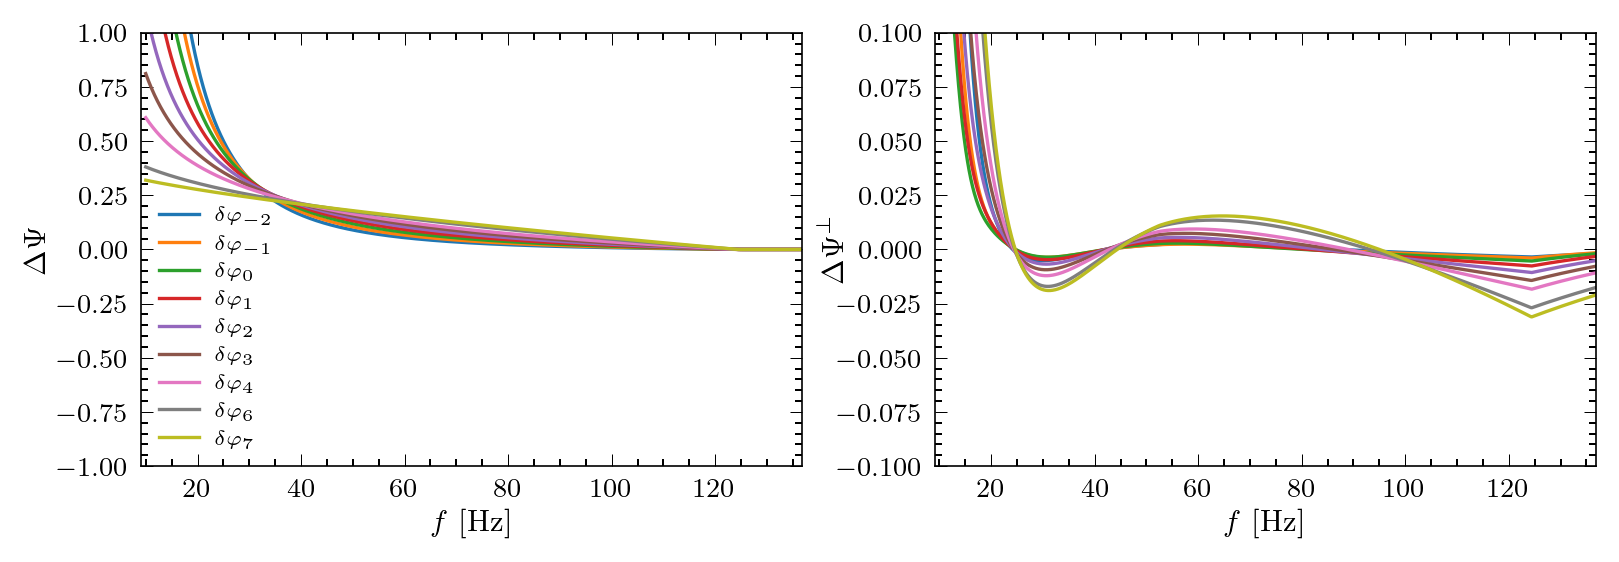

In [7]:

default_figsize = plt.rcParams["figure.figsize"]
fig, axes = plt.subplots(1, 2, figsize=(default_figsize[0] * 510/246, default_figsize[1]))


for kinj in [-2, -1, 0, 1, 2, 3, 4, 6, 7]:
    res = get_stuff(kinj)
    freqs = res['freqs']
    dpsi_inj = res['dpsi_inj']
    dpsi_perp = res['dpsi_perp']
    i = np.argmin((freqs - obj.fend) ** 2)
    
    line, = axes[0].plot(freqs, dpsi_inj, label=rf"$\delta\varphi_{{ {kinj} }}$")
    axes[1].plot(freqs, np.real(dpsi_perp ), c=line.get_color())

axes[0].set_xlim(obj.fmin/1.1, obj.fend * 1.1)
axes[0].set_ylim(-1, 1)
axes[0].set_xlabel("$f$ [Hz]")
axes[0].set_ylabel("$\Delta\Psi$")
axes[0].legend(loc=0)


axes[1].set_xlim(obj.fmin/1.1, obj.fend * 1.1)
axes[1].set_ylim(-0.1, 0.1)
axes[1].set_xlabel("$f$ [Hz]")
axes[1].yaxis.set_label_coords(-0.13, 2.)
axes[1].set_ylabel("$\Delta\Psi^\perp$")
# fig.suptitle("$M_c = 3$")
# plt.savefig(datestr + "-dephasing-PN-150914.pdf", bbox_inches='tight', pad_inches=0)
plt.show()



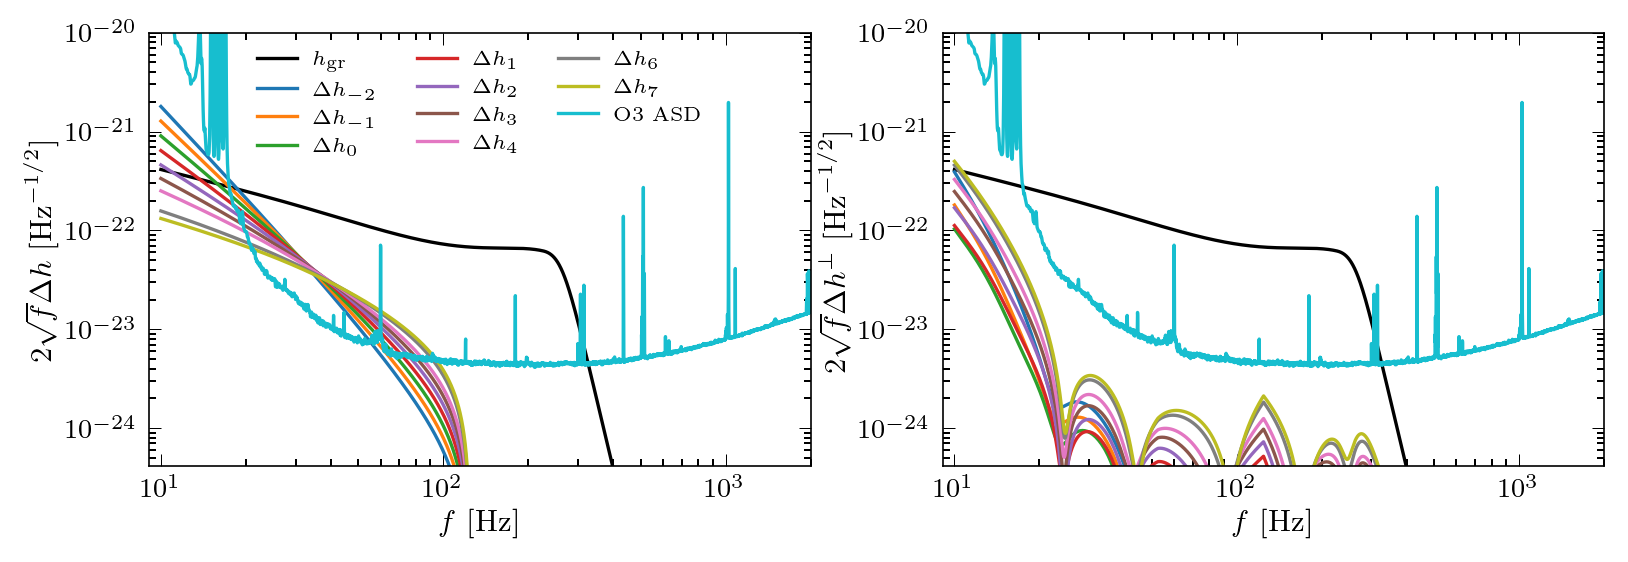

,$\rho$
$\rho_{gr}$,39.97
$\rho_{dh}$,5.00
$\rho_{dh_\perp}$,0.58
$\rho_{dh_\parallel}$,4.97


In [8]:
res = get_stuff(3)
freqs = res['freqs']
h = res['h']
asd = obj.psdO3**(1/2)
# plt.loglog(freqs, 2*np.sqrt(freqs)*np.abs(h))

default_figsize = plt.rcParams["figure.figsize"]
fig, axes = plt.subplots(1, 2, figsize=(default_figsize[0] * 510/246, default_figsize[1]))

line, = axes[0].loglog(freqs, 2*np.sqrt(freqs)*np.abs(h), label=r"$h_\mathrm{gr}$", c = "k")
axes[1].loglog(freqs, 2*np.sqrt(freqs)*np.abs(h), c=line.get_color())



for kinj in [-2, -1, 0, 1, 2, 3, 4, 6, 7]:
    res = get_stuff(kinj)
    freqs = res['freqs']
    dh = res['dh']
    dh_perp = res['dh_perp']

    # print()
    
    
    # line, = axes[0].plot(freqs, dpsi_inj - dpsi_inj[i], label=rf"$\delta\varphi_{{ {kinj} }}$")
    # axes[1].plot(freqs, np.real(dpsi_perp - dpsi_perp[i]), c=line.get_color())
    line, = axes[0].plot(freqs, 2*np.sqrt(freqs)*np.abs(dh), label=rf"$\Delta h_{{ {kinj} }}$")
    axes[1].plot(freqs, 2*np.sqrt(freqs)*np.abs(dh_perp), c=line.get_color())

line, = axes[0].plot(freqs, asd, label=r"O3 ASD")
axes[1].plot(freqs, asd, c=line.get_color())

axes[0].legend(loc=0)
axes[0].set_xlim(obj.fmin/1.1, 2000)
axes[0].set_ylim(np.min(asd)/1e1, 1e-20)
axes[0].set_xlabel("$f$ [Hz]")
axes[0].set_ylabel("$2\sqrt{f}  \Delta h$  [Hz$^{-1/2}$]")
axes[0].legend(loc=0,ncol=3)

axes[1].set_xlim(obj.fmin/1.1, 2000)
axes[1].set_ylim(np.min(asd)/1e1, 1e-20)
axes[1].set_xlabel("$f$ [Hz]")
axes[1].set_ylabel("$2\sqrt{f} \Delta h^\perp$  [Hz$^{-1/2}$]")
# fig.suptitle("$M_c = 3$")
# plt.savefig(datestr + "-amplitude-PN-150914.pdf", bbox_inches='tight', pad_inches=0)
plt.show()

snr_latex = [r"$\rho_{gr}$","$\rho_{dh}$","$\rho_{dh_\perp}$","$\rho_{dh_\parallel}$"]
# print([res['snr'], res['snr_dh'], res['snr_dhperp'], res['snr_dhpara']])
pd.DataFrame([res['snr'], res['snr_dh'], res['snr_dhperp'], res['snr_dhpara']],snr_latex, [r"$\rho$"]).round(2)

In [9]:
def fish(freqs, dh, par, idx_par, psd, log_flag):
    n_pt = len(freqs)
    n_dof = len(idx_par)

    dh_arr = jnp.zeros([n_dof, n_pt], dtype=jnp.complex128)

    # Convert idx_par to a list for static looping
    idx_list = list(idx_par.keys())
    for idx in idx_list:
        idx_position = idx_par[idx]
        dh_arr = dh_arr.at[idx_position, :].set(dh[idx])

        # Use jax.lax.cond for conditional multiplication
        dh_arr = dh_arr.at[idx_position, :].set(
            jax.lax.cond(
                log_flag[idx],
                lambda x: x * par[idx],
                lambda x: x,
                dh_arr[idx_position, :]
            )
        )

    gamma = jnp.zeros([n_dof, n_dof], dtype=jnp.float64)

    # Use static loops
    for i in range(n_dof):
        for j in range(i, n_dof):
            gamma = gamma.at[i, j].set(
                jnp.real(lib.innprod(dh_arr[i, :], dh_arr[j, :], psd, freqs))
            )
        for j in range(i):
            gamma = gamma.at[i, j].set(jnp.conj(gamma[j, i]))

    return gamma

In [14]:
def compute_mm(kinj, krec, idx_ignore = None):
    norm = lib.get_dpsi_ppe(20, x, kinj)- lib.get_dpsi_ppe(6000, x, kinj)
    dphik = 1/norm
    dpsi_inj = dphik*lib.get_dpsi_ppe(obj.freqs, x, kinj)
    dpsi_rec = lib.get_dpsi_ppe(freqs, x, krec)

    Dh = {}
    
    for d in ["H1", "L1", "V1"]:
        Dh[d] = 1j * dpsi_inj * hgr[d] 
    normarr = [lib.innprod(Dh[d], Dh[d], obj.psdO3, obj.freqs) for d in ["H1", "L1", "V1"]]
    norm = np.sum(normarr)**(1/2) / 5
    dpsi_inj = dpsi_inj/norm
    for d in ["H1", "L1", "V1"]:
        Dh[d] = Dh[d]/norm


    

    X = x.copy()
    X['phi_k'] = 0
    param = paramgr[:idx_ignore] + ["phi_k"]

    fi = obj.compute_joint_fish(X, param, k = krec)
    bias_ip = obj.compute_biasip(X, Dh, param, k = krec)

    idx_par = {param[i] : i for i in range(len(param))}
    log_flag = {param[i] : 0 for i in range(len(param))}; log_flag["M_c"] = 1; log_flag["d_L"] = 1
    
    cov = jnp.linalg.inv(fi)
    dx_bias = np.array(cov @ bias_ip)
    dx_stat = np.diagonal(np.array(cov ))**(1/2)

    for p in param:
        if log_flag[p]:
            i = idx_par[p]
            dx_bias[i] = dx_bias[i]*X[p]
            dx_stat[i] = dx_stat[i]*X[p]

    dhpara = {}
    dhperp = {}
    for d in ["H1", "L1", "V1"]:
        dhpara[d] = jnp.zeros_like(freqs)
        for p in param:
            if p == "phi_k":
                dhpara[d] = dhpara[d] + dx_bias[idx_par[p]]*1j*dpsi_rec*hgr[d]
            else:
                dhpara[d] = dhpara[d] + dx_bias[idx_par[p]]*dhgr[d][p]
        dhperp[d] = Dh[d] - dhpara[d]

    dhperp_sq = np.sum([lib.innprod(dhperp[d], dhperp[d], obj.psdO3, obj.freqs) for d in ["H1", "L1", "V1"]])
    hgr_sq = np.sum([lib.innprod(hgr[d], hgr[d], obj.psdO3, obj.freqs) for d in ["H1", "L1", "V1"]])

    mm = (1/2 * dhperp_sq/hgr_sq)
    return mm 



0
1
2
3
4
5
6
7
8


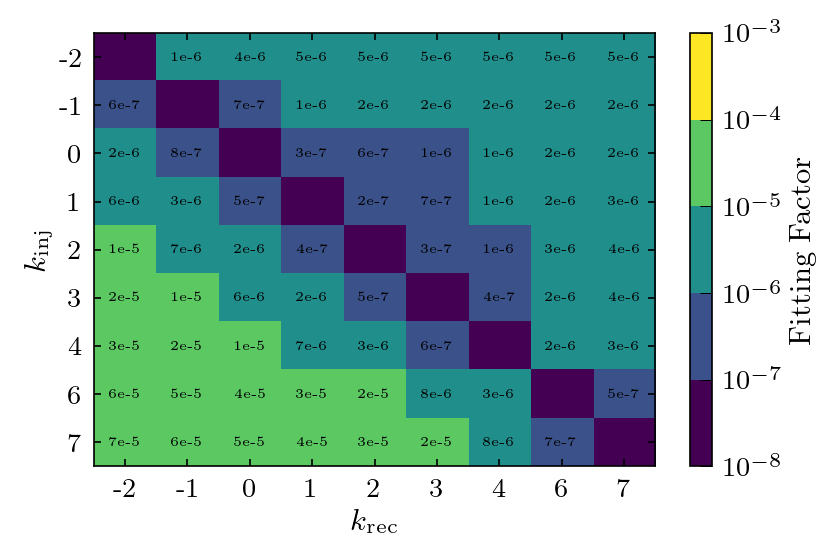

In [ ]:
# compute_mm(4,2)
ii = [-2, -1, 0, 1, 2, 3, 4, 6, 7]
idx = np.arange(len(ii))
mmarr = np.zeros((len(ii),len(ii)))
for i in idx:
    print(idx[i])
    for j in idx:
        # print(i,j)
        mmarr[idx[i],idx[j]] = np.real(compute_mm(ii[i], ii[j]))


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter

default_figsize = plt.rcParams["figure.figsize"]
fig, ax = plt.subplots()


mmarr_safe = np.where(mmarr > 0, mmarr, np.nan)  
log_mmarr = np.log10(mmarr_safe)


levels = np.arange(-8, -2, 1)  
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)


plt.imshow(log_mmarr, cmap='viridis', interpolation='nearest', aspect='auto', norm=norm)

# Add discrete color bar
cbar = plt.colorbar(ticks=levels)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: fr"$10^{{{int(x)}}}$"))
cbar.set_label(r'Fitting Factor')


# Label axes
plt.xlabel(r"$k_{\mathrm{rec}}$")
plt.ylabel(r"$k_{\mathrm{inj}}$")


mmarr_safe[mmarr_safe<1e-20] = 0
for i in idx:
    for j in idx:
            text = f"{mmarr_safe[i, j]:.0e}".replace("e+0", "e").replace("e+", "e").replace("e-0", "e-")
            if i != j:
                ax.text(j, i, text, ha="center", va="center", color="k", fontsize=4, weight="bold")
plt.xticks(ticks=idx, labels=ii)
plt.yticks(ticks=idx, labels=ii)
ax.tick_params(which='minor', bottom=False, left=False, top=False, right=False)
ax.tick_params(axis='x', length=2, width=0.5)  # Make x-tick marks smaller
ax.tick_params(axis='y', length=2, width=0.5)  # Make y-tick marks smaller

# plt.savefig(datestr + "-ff-pn-tests-prec.pdf", bbox_inches='tight', pad_inches=0)
plt.show()


0
1
2
3
4
5
6
7
8


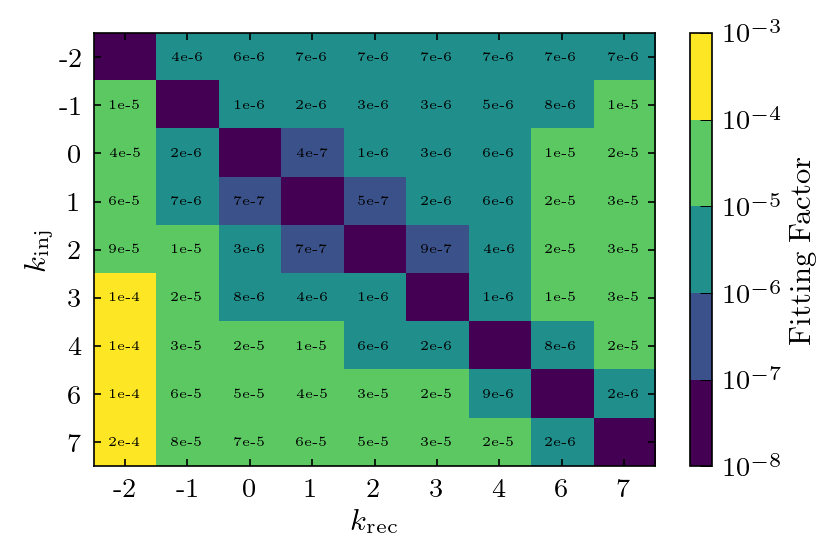

In [18]:
# compute_mm(4,2)
ii = [-2, -1, 0, 1, 2, 3, 4, 6, 7]
idx = np.arange(len(ii))
mmarr = np.zeros((len(ii),len(ii)))
for i in idx:
    print(idx[i])
    for j in idx:
        # print(i,j)
        mmarr[idx[i],idx[j]] = np.real(compute_mm(ii[i], ii[j],idx_ignore=-2))


import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import FuncFormatter

default_figsize = plt.rcParams["figure.figsize"]
fig, ax = plt.subplots()


mmarr_safe = np.where(mmarr > 0, mmarr, np.nan)  
log_mmarr = np.log10(mmarr_safe)


levels = np.arange(-8, -2, 1)  
norm = mcolors.BoundaryNorm(boundaries=levels, ncolors=256)


plt.imshow(log_mmarr, cmap='viridis', interpolation='nearest', aspect='auto', norm=norm)

# Add discrete color bar
cbar = plt.colorbar(ticks=levels)
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: fr"$10^{{{int(x)}}}$"))
cbar.set_label(r'Fitting Factor')


# Label axes
plt.xlabel(r"$k_{\mathrm{rec}}$")
plt.ylabel(r"$k_{\mathrm{inj}}$")


mmarr_safe[mmarr_safe<1e-20] = 0
for i in idx:
    for j in idx:
            text = f"{mmarr_safe[i, j]:.0e}".replace("e+0", "e").replace("e+", "e").replace("e-0", "e-")
            if i != j:
                ax.text(j, i, text, ha="center", va="center", color="k", fontsize=4, weight="bold")
plt.xticks(ticks=idx, labels=ii)
plt.yticks(ticks=idx, labels=ii)
ax.tick_params(which='minor', bottom=False, left=False, top=False, right=False)
ax.tick_params(axis='x', length=2, width=0.5)  # Make x-tick marks smaller
ax.tick_params(axis='y', length=2, width=0.5)  # Make y-tick marks smaller

# plt.savefig(datestr + "-ff-pn-tests-nospin.pdf", bbox_inches='tight', pad_inches=0)
plt.show()
